In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [16]:
#LoadImageHAM10000  
base_skin_dir = os.path.join('data')

image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis-like lesions ',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

print(image_path_dict)

{'ISIC_0024306': 'data\\ISIC_0024306.jpg', 'ISIC_0024307': 'data\\ISIC_0024307.jpg', 'ISIC_0024308': 'data\\ISIC_0024308.jpg', 'ISIC_0024309': 'data\\ISIC_0024309.jpg', 'ISIC_0024310': 'data\\ISIC_0024310.jpg', 'ISIC_0024311': 'data\\ISIC_0024311.jpg', 'ISIC_0024312': 'data\\ISIC_0024312.jpg', 'ISIC_0024313': 'data\\ISIC_0024313.jpg', 'ISIC_0024314': 'data\\ISIC_0024314.jpg', 'ISIC_0024315': 'data\\ISIC_0024315.jpg', 'ISIC_0024316': 'data\\ISIC_0024316.jpg', 'ISIC_0024317': 'data\\ISIC_0024317.jpg', 'ISIC_0024318': 'data\\ISIC_0024318.jpg', 'ISIC_0024319': 'data\\ISIC_0024319.jpg', 'ISIC_0024320': 'data\\ISIC_0024320.jpg', 'ISIC_0024321': 'data\\ISIC_0024321.jpg', 'ISIC_0024322': 'data\\ISIC_0024322.jpg', 'ISIC_0024323': 'data\\ISIC_0024323.jpg', 'ISIC_0024324': 'data\\ISIC_0024324.jpg', 'ISIC_0024325': 'data\\ISIC_0024325.jpg', 'ISIC_0024326': 'data\\ISIC_0024326.jpg', 'ISIC_0024327': 'data\\ISIC_0024327.jpg', 'ISIC_0024328': 'data\\ISIC_0024328.jpg', 'ISIC_0024329': 'data\\ISIC_00243

In [17]:
df = pd.read_csv(os.path.join('data', 'dataset.csv'))
df['path'] = df['image'].map(image_path_dict.get)

df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,path
0,ISIC_0024306,0,1,0,0,0,0,0,data\ISIC_0024306.jpg
1,ISIC_0024307,0,1,0,0,0,0,0,data\ISIC_0024307.jpg
2,ISIC_0024308,0,1,0,0,0,0,0,data\ISIC_0024308.jpg
3,ISIC_0024309,0,1,0,0,0,0,0,data\ISIC_0024309.jpg
4,ISIC_0024310,1,0,0,0,0,0,0,data\ISIC_0024310.jpg


In [18]:
df.isnull().sum()

image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
path     0
dtype: int64

In [19]:
print(df.dtypes)

image    object
MEL       int64
NV        int64
BCC       int64
AKIEC     int64
BKL       int64
DF        int64
VASC      int64
path     object
dtype: object


In [20]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

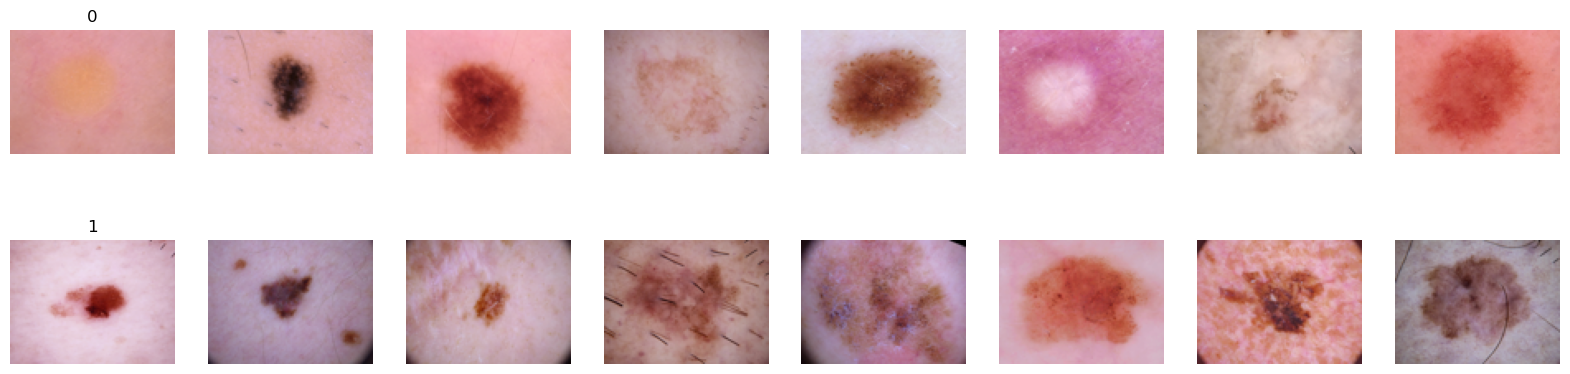

In [21]:
n_samples = 8
fig, m_axs = plt.subplots(2, n_samples, figsize = (20, 5))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['MEL']).groupby('MEL')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [22]:
# Checking the image size distribution
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    100
Name: image, dtype: int64

In [23]:
features=df.drop(columns=['MEL'],axis=1)
target=df['MEL']

In [24]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [25]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [26]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)


In [27]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [28]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [45]:
model = Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(75, 100, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 73, 98, 64)        1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 71, 96, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 35, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 33, 46, 64)        36928     
                                                                 
 conv2d_13 (Conv2D)          (None, 31, 44, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 22, 64)       0         
 2D)                                                  

In [46]:
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [47]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)

In [48]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check accuracy
    if(logs.get('loss') < 0.4):

      # Stop if threshold is met
      print("\nLoss is lower than 0.4 so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

In [49]:
batch_size = 10
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 100, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=callbacks
                            )

Epoch 1/100
7/7 [==============================] - 3s 314ms/step - loss: 1.8802 - accuracy: 0.7903 - val_loss: 1.8146 - val_accuracy: 0.8750
Epoch 2/100
7/7 [==============================] - 2s 259ms/step - loss: 1.7925 - accuracy: 0.9516 - val_loss: 1.7926 - val_accuracy: 0.8750
Epoch 3/100
7/7 [==============================] - 2s 267ms/step - loss: 1.7666 - accuracy: 0.9677 - val_loss: 1.7726 - val_accuracy: 0.8750
Epoch 4/100
7/7 [==============================] - 2s 290ms/step - loss: 1.7493 - accuracy: 0.9429 - val_loss: 1.7519 - val_accuracy: 0.8750
Epoch 5/100
7/7 [==============================] - 2s 262ms/step - loss: 1.7280 - accuracy: 0.9355 - val_loss: 1.7317 - val_accuracy: 0.8750
Epoch 6/100
7/7 [==============================] - 2s 291ms/step - loss: 1.7051 - accuracy: 0.9429 - val_loss: 1.7115 - val_accuracy: 0.8750
Epoch 7/100
7/7 [==============================] - 2s 277ms/step - loss: 1.6858 - accuracy: 0.9355 - val_loss: 1.6918 - val_accuracy: 0.8750
Epoch 8/100
7

In [52]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

1/1 [==============================] - 0s 88ms/step - loss: 0.6985 - accuracy: 0.8750
Validation: accuracy = 0.875000  ;  loss_v = 0.698473
Test: accuracy = 0.850000  ;  loss = 0.749832
